# Import Packages

In [1]:
import re
import sys
import time
import warnings
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from scipy.optimize import linear_sum_assignment

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize

from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix,
)

from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper, DeadlineStopper
from skopt.space import Categorical
from skopt.utils import point_asdict

warnings.filterwarnings("ignore", category=UserWarning)

# Load Data

In [2]:
df_min_cleaned = pd.read_csv("min_cleaned_tweets.csv")

df_min_cleaned_sample = pd.read_csv("min_cleaned_sample_tweets.csv")

# GloVe

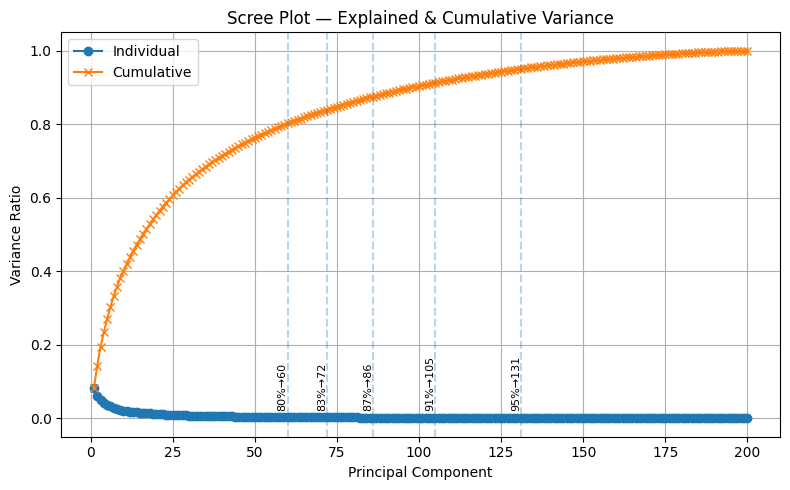

PCA n_components candidates (80–95% cum var): [60, 72, 86, 105, 131]

=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===
[Bayes] iter   4/60 ( 6.7%) | last 14.34s avg 14.34s | elapsed  0.2m ETA ~13.4m | branch pca+kmeans
[Bayes] iter   8/60 (13.3%) | last 12.27s avg 13.30s | elapsed  0.4m ETA ~11.5m | branch pca+kmeans
[Bayes] iter  12/60 (20.0%) | last  1.90s avg  9.50s | elapsed  0.5m ETA ~ 7.6m | branch pca+kmeans
[Bayes] iter  16/60 (26.7%) | last  2.80s avg  7.83s | elapsed  0.5m ETA ~ 5.7m | branch pca+kmeans
[Bayes] iter  20/60 (33.3%) | last  9.95s avg  8.25s | elapsed  0.7m ETA ~ 5.5m | branch pca+kmeans
[Bayes] iter  24/60 (40.0%) | last  2.28s avg  7.26s | elapsed  0.7m ETA ~ 4.4m | branch pca+kmeans
[Bayes] iter  28/60 (46.7%) | last  2.86s avg  6.63s | elapsed  0.8m ETA ~ 3.5m | branch pca+kmeans
[Bayes] iter  32/60 (53.3%) | last  3.50s avg  6.24s | elapsed  0.8m ETA ~ 2.9m | branch pca+kmeans
[Bayes] iter  36/60 (60.0%) | last  3.54s avg  5.94s | elapsed  0.9m E

,estimator,ClusteringPipeline()
,search_spaces,"[{'model': Categorical(c...), prior=None), 'n_components': Categorical(c...), prior=None), 'reducer': Categorical(c...), prior=None)}, {'cov_type': Categorical(c...), prior=None), 'model': Categorical(c...), prior=None), 'n_components': Categorical(c...), prior=None), 'reducer': Categorical(c...), prior=None)}, ...]"
,optimizer_kwargs,None
,n_iter,60
,scoring,None
,fit_params,None
,n_jobs,-1
,n_points,4
,iid,'deprecated'
,refit,True
,cv,"[(array([ 0, ...shape=(2928,)), ...)]"


In [8]:
# ---------------------------
# CONFIG
# ---------------------------
GLOVE_TXT = "./glove.twitter.27B.200d.txt"
EMB_DIM     = 200
RANDOM_STATE = 42

# ---------------------------
# Load GloVe
# ---------------------------
def load_glove(path, emb_dim=200):
    vocab = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            if len(parts) < emb_dim + 1:  # skip short lines
                continue
            word = parts[0]
            vec = np.asarray(parts[1:1+emb_dim], dtype=np.float32)
            vocab[word] = vec
    return vocab

def text_to_glove_avg(sent, glove, emb_dim=200):
    toks = [re.sub(r'^\W+|\W+$', '', t.lower()) for t in str(sent).split()]
    vecs = [glove[t] for t in toks if t in glove]
    if not vecs:
        return np.zeros(emb_dim, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

def batch_embed(texts, glove, emb_dim=200):
    return np.vstack([text_to_glove_avg(s, glove, emb_dim) for s in texts])

# ---------------------------
# Metrics
# ---------------------------
def hungarian_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_full(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = hungarian_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# ---------------------------
# Prepare Data
# ---------------------------
texts_sample = df_min_cleaned_sample["text"].astype(str).tolist()
texts_full   = df_min_cleaned["text"].astype(str).tolist()

le = LabelEncoder()

all_labels = pd.concat([
    df_min_cleaned["airline_sentiment"].astype(str),
    df_min_cleaned_sample["airline_sentiment"].astype(str)
], axis=0)
le.fit(all_labels)

# Transform in the same row order as texts_sample/texts_full 
y_full   = le.transform(df_min_cleaned["airline_sentiment"].astype(str))
y_sample = le.transform(df_min_cleaned_sample["airline_sentiment"].astype(str))

glove = load_glove(GLOVE_TXT, EMB_DIM)
X_glove_sample = batch_embed(texts_sample, glove, EMB_DIM)
X_glove_full   = batch_embed(texts_full, glove, EMB_DIM)

# ---------------------------
# PCA Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------
def pick_pca_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    if max_components is None:
        max_components = min(EMB_DIM, X.shape[1])
    Xs   = StandardScaler().fit_transform(X)
    pca  = PCA(n_components=max_components, random_state=RANDOM_STATE)
    pca.fit(Xs)
    evr  = pca.explained_variance_ratio_
    cum  = np.cumsum(evr)

    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # dedupe while preserving order
    seen = set(); comps_unique = []
    for c in comps:
        if c not in seen:
            comps_unique.append(c); seen.add(c)

    # ensure exactly k values (best-effort padding)
    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k-1))
        candidate = min(max_components, comps_unique[-1] + step)
        if candidate not in seen:
            comps_unique.append(candidate); seen.add(candidate)
        else:
            candidate = min(max_components, candidate+1)
            if candidate not in seen:
                comps_unique.append(candidate); seen.add(candidate)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    if plot:
        xs = np.arange(1, len(evr)+1)
        plt.figure(figsize=(8,5))
        plt.plot(xs, evr, marker='o', label='Individual')
        plt.plot(xs, cum, marker='x', label='Cumulative')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t*100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('Scree Plot — Explained & Cumulative Variance')
        plt.xlabel('Principal Component'); plt.ylabel('Variance Ratio')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return comps_unique, cum

pca_candidates, _cum = pick_pca_candidates(
    X_glove_sample, pct_low=0.80, pct_high=0.95, k=5, max_components=EMB_DIM, plot=True
)
print("PCA n_components candidates (80–95% cum var):", pca_candidates)

# Fixed UMAP candidate grids
umap_neighbors  = [15, 30, 45, 60, 75, 100, 150, 200]
umap_min_dist   = [0.1, 0.2, 0.3, 0.4, 0.5]
umap_components = [16, 32, 48, 64, 96, 128]

# ---------------------------
# ClusteringPipeline class (for BayesSearchCV)
# ---------------------------
_LAST_TRIAL = deque(maxlen=1)

class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        # record the params actually used (for robust logging)
        _LAST_TRIAL.clear()
        _LAST_TRIAL.append({
            'reducer'          : self.reducer,
            'n_components'     : self.n_components,
            'n_neighbors'      : self.n_neighbors,
            'min_dist'         : self.min_dist,
            'n_components_umap': self.n_components_umap,
            'model'            : self.model,
            'cov_type'         : self.cov_type,
            'linkage'          : self.linkage,
        })
        # ---------------- Reducer ----------------
        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE,
                n_epochs=120,
                low_memory=True
            ).fit_transform(X_l2)

        # ---------------- Clustering ----------------
        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan', random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:  # Agglo
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        # store for score()
        self.labels_ = labels
        self.X_use_  = X_use
        self.score_  = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_

# ---------------------------
# Bayesian Search Space 
# ---------------------------
search_spaces = [
    # PCA + KMeans
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # PCA + GMM
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # PCA + Agglo (no 'ward' since metric='cosine')
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },

    # UMAP + KMeans
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['kmeans'],      name='model'),
    },
    # UMAP + GMM
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['gmm'],         name='model'),
        'cov_type'          : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # UMAP + Agglo
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['agglo'],       name='model'),
        'linkage'           : Categorical(['average','complete','single'], name='linkage'),
    },
]

# --- progress/timing callback for BayesSearchCV (with robust fallback) ---
TOTAL_ITERS = 60  # keep in sync with BayesSearchCV(n_iter=...)

_timings = []
_start = [None]
_prev  = [None]

def _short_params(d):
    keys = [
        'reducer','n_components','n_neighbors','min_dist','n_components_umap',
        'model','cov_type','linkage'
    ]
    return {k: d[k] for k in keys if k in d}

def _infer_branch_from_space(space):
    """Infer branch name (reducer+model) from single-choice categories in subspace."""
    reducer = model = None
    for dim in getattr(space, "dimensions", []):
        cats = getattr(dim, "categories", None)
        if not cats or not hasattr(cats, "__iter__"):
            continue
        if len(cats) == 1:
            v = cats[0]
            if v in ("pca", "umap"):
                reducer = v
            elif v in ("kmeans", "gmm", "agglo"):
                model = v
    return f"{reducer or '?'}+{model or '?'}"

def progress_callback(res):
    import time, numpy as np
    now = time.perf_counter()
    if _start[0] is None:
        _start[0] = now
    if _prev[0] is not None:
        _timings.append(now - _prev[0])

    k = len(res.x_iters)
    avg = float(np.mean(_timings)) if _timings else 0.0
    elapsed = now - _start[0]
    remaining = max(TOTAL_ITERS - k, 0) * (avg if avg > 0 else 0.0)

    # Try to get the reducer/model from the latest evaluated point
    branch = None
    try:
        if res.x_iters:
            last_params = point_asdict(res.space, res.x_iters[-1])
            r, m = last_params.get("reducer"), last_params.get("model")
            if r and m:
                branch = f"{r}+{m}"
    except Exception:
        pass

    # Fallback: infer directly from this subspace definition
    if branch is None:
        branch = _infer_branch_from_space(res.space)

    last_dt = _timings[-1] if _timings else 0.0
    print(
        f"[Bayes] iter {k:>3}/{TOTAL_ITERS} ({k/TOTAL_ITERS:5.1%}) "
        f"| last {last_dt:5.2f}s avg {avg:5.2f}s "
        f"| elapsed {elapsed/60:4.1f}m ETA ~{remaining/60:4.1f}m "
        f"| branch {branch}",
        flush=True
    )
    _prev[0] = now
    return False

# ---------------------------
# Run Bayesian SearchCV
# ---------------------------
n = X_glove_sample.shape[0]
dummy_y = np.zeros(n, dtype=int)
cv_full = [(np.arange(n), np.arange(n))]

search = BayesSearchCV(
    estimator=ClusteringPipeline(),
    search_spaces=search_spaces,           
    n_iter=TOTAL_ITERS,
    random_state=RANDOM_STATE,
    scoring=None,                          # uses estimator.score() (silhouette)
    cv=cv_full,
    n_points=4,                            # parallel proposals
    n_jobs=-1,                             # parallel fits
    return_train_score=False
)

print("\n=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===")
callbacks = [
    DeltaYStopper(delta=1e-4, n_best=15),
    progress_callback
]

# prime timers for clean first measurement
_prev[0] = time.perf_counter()
_start[0] = _prev[0]

search.fit(X_glove_sample, dummy_y, callback=callbacks)

In [9]:
# ==========================================================
# Final (Full-Data) ClusteringPipeline — no speed tweaks
# ==========================================================
class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE
            ).fit_transform(X_l2)

        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan',
                            random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:  # Agglomerative
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        self.labels_ = labels
        self.X_use_ = X_use
        self.score_ = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_


# ==========================================================
# Extract best per-branch on 20% subset
# ==========================================================
def _params_compact(d):
    order = ["reducer","model","n_components",
             "n_neighbors","min_dist","n_components_umap",
             "cov_type","linkage"]
    return ", ".join(f"{k}={d[k]}" for k in order if k in d and pd.notnull(d[k]))

cv = pd.DataFrame(search.cv_results_)
param_cols = [c for c in cv.columns if c.startswith("param_")]
score_col  = "mean_test_score"  # silhouette

# Ensure plain Python types
for c in param_cols:
    cv[c] = cv[c].apply(lambda x: x if isinstance(x, (str,int,float,type(None))) else str(x))

cv["branch"] = cv.apply(lambda r: f"{r.get('param_reducer','?')}+{r.get('param_model','?')}", axis=1)
best_idx = cv.groupby("branch")[score_col].idxmax()
best_rows = cv.loc[best_idx].reset_index(drop=True)

subset_records = []
for _, r in best_rows.iterrows():
    params = {p.replace("param_",""): r[p] for p in param_cols if pd.notnull(r[p])}
    subset_records.append({
        "branch": r["branch"],
        "best_sil_subset": round(float(r[score_col]), 4),
        **params
    })

df_best_subset = pd.DataFrame(subset_records).sort_values("branch")

print("\n================ Best Parameters per Branch (20% subset) ================\n")
print(df_best_subset[[
    "branch","best_sil_subset","reducer","model","n_components",
    "n_neighbors","min_dist","n_components_umap","cov_type","linkage"
]].to_string(index=False))


# ==========================================================
# Refit each best branch on FULL data + compute metrics
# ==========================================================
final_rows = []
for _, row in df_best_subset.iterrows():
    params = {}
    for k in ["reducer","model","n_components","n_neighbors","min_dist",
              "n_components_umap","cov_type","linkage"]:
        if k in row and pd.notnull(row[k]):
            val = row[k]
            if k in ["n_components","n_neighbors","n_components_umap"] and not pd.isna(val):
                val = int(val)
            if k == "min_dist" and not pd.isna(val):
                val = float(val)
            params[k] = val

    mdl = ClusteringPipeline(**params)
    mdl.fit(X_glove_full)
    labels = mdl.labels_
    metric = getattr(mdl, "metric", "cosine")
    sil, ari, nmi, acc = evaluate_full(mdl.X_use_, y_full, labels, metric)

    final_rows.append({
        "branch": row["branch"],
        "Silhouette": round(sil, 3),
        "ARI": round(ari, 3),
        "NMI": round(nmi, 3),
        "Hungarian": round(acc, 3),
        "Params": _params_compact(params)
    })

df_final = pd.DataFrame(final_rows).sort_values("branch")

print("\n================ Final Evaluation on Full Minimal-Cleaned Data (All 6 best models) ================\n")
print(df_final[["branch","Silhouette","ARI","NMI","Hungarian","Params"]].to_string(index=False))


# ==========================================================
# Quick metric winners
# ==========================================================
for metric in ["Silhouette","ARI","NMI","Hungarian"]:
    r = df_final.loc[df_final[metric].idxmax()]
    print(f"\nWinner by {metric}: {r['branch']} | {metric}={r[metric]:.3f} | {r['Params']}")



================ Best Parameters per Branch (20% subset) ================

     branch  best_sil_subset reducer  model  n_components  n_neighbors  min_dist  n_components_umap  cov_type  linkage
  pca+agglo           0.0436     pca  agglo          60.0          NaN       NaN                NaN       NaN  average
    pca+gmm           0.3731     pca    gmm          86.0          NaN       NaN                NaN      tied      NaN
 pca+kmeans           0.0992     pca kmeans          60.0          NaN       NaN                NaN       NaN      NaN
 umap+agglo           0.4029    umap  agglo           NaN         30.0       0.1               16.0       NaN complete
   umap+gmm           0.2269    umap    gmm           NaN         15.0       0.1               16.0 spherical      NaN
umap+kmeans           0.3833    umap kmeans           NaN         15.0       0.1               32.0       NaN      NaN

================ Final Evaluation on Full Minimal-Cleaned Data (All 6 best models) =======

# Visualisation

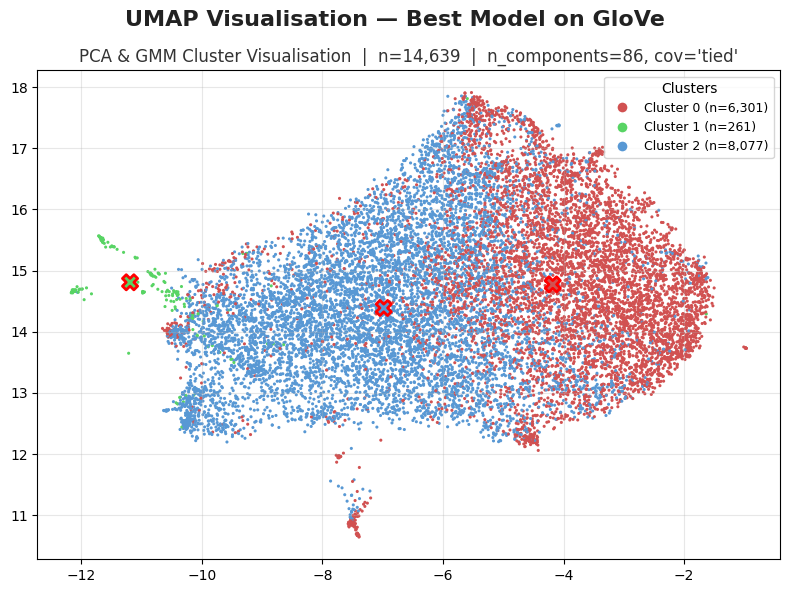

In [6]:
# ---------------------------
# CONFIG
# ---------------------------
GLOVE_TXT = "./glove.twitter.27B.200d.txt"
EMB_DIM = 200
RANDOM_STATE = 42
N_CLUSTERS = 3  # neg / neu / pos
palette = ["#d15151", "#58d464", "#5898d4"]  # red / green / blue

BEST_N_COMPONENTS = 86
BEST_COV_TYPE     = "tied"

# ---------------------------
# Load GloVe
# ---------------------------
def load_glove(path, emb_dim=200):
    vocab = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            if len(parts) < emb_dim + 1:  # skip short lines
                continue
            word = parts[0]
            vec = np.asarray(parts[1:1+emb_dim], dtype=np.float32)
            vocab[word] = vec
    return vocab

def text_to_glove_avg(sent, glove, emb_dim=200):
    toks = [re.sub(r'^\W+|\W+$', '', t.lower()) for t in str(sent).split()]
    vecs = [glove[t] for t in toks if t in glove]
    if not vecs:
        return np.zeros(emb_dim, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

def batch_embed(texts, glove, emb_dim=200):
    return np.vstack([text_to_glove_avg(s, glove, emb_dim) for s in texts])

# ---------------------------
# Data + Embeddings 
# ---------------------------
# prefer 'clean_text' if present, otherwise 'text'
_text_col = "clean_text" if "clean_text" in df_min_cleaned.columns else "text"
texts_full = df_min_cleaned[_text_col].astype(str).tolist()

# y / label encoder (only if not already defined)
if "le" not in globals():
    le = LabelEncoder()
    le.fit(df_min_cleaned["airline_sentiment"].astype(str))
if "y_full" not in globals():
    df_min_cleaned["label_encoded"] = le.transform(df_min_cleaned["airline_sentiment"].astype(str))
    y_full = df_min_cleaned["label_encoded"].values

# Use existing GloVe embeddings if present, else build from earlier helpers defined
if "X_glove_full" not in globals():
    # expects already defined: load_glove, text_to_glove_avg, batch_embed, GLOVE_TXT
    glove = load_glove(GLOVE_TXT, EMB_DIM)
    X_glove_full = batch_embed(texts_full, glove, EMB_DIM)

# ---------------------------
# Reduce (PCA winner) + Cluster (GMM winner)
# ---------------------------
X_std = StandardScaler().fit_transform(X_glove_full)
X_red = PCA(n_components=BEST_N_COMPONENTS, random_state=RANDOM_STATE).fit_transform(X_std)

gmm = GaussianMixture(
    n_components=N_CLUSTERS,
    covariance_type=BEST_COV_TYPE,
    n_init=10,
    random_state=RANDOM_STATE
)
labels = gmm.fit_predict(X_red)

# ---------------------------
# 2D UMAP for visualisation 
# ---------------------------
umap_2d = umap.UMAP(
    n_neighbors=50, min_dist=0.1, n_components=2,
    metric="euclidean", random_state=RANDOM_STATE
)
X_vis = umap_2d.fit_transform(X_red)

# ---------------------------
# Plot (single panel, clusters + centroids)
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# map cluster labels -> colors
colors = np.array(palette)[labels]
ax.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, s=5, edgecolor="none")

# Legend with counts
unique, counts = np.unique(labels, return_counts=True)
size_map = dict(zip(unique, counts))
handles = [
    plt.Line2D([0], [0],
               marker='o', color='w',
               label=f"Cluster {k} (n={size_map.get(k, 0):,})",
               markerfacecolor=palette[k], markersize=8)
    for k in range(N_CLUSTERS)
]
ax.legend(handles=handles, title="Clusters", loc="best", fontsize=9)

# Centroids (in 2D space)
centroids = np.vstack([X_vis[labels == k].mean(axis=0) for k in range(N_CLUSTERS)])
ax.scatter(centroids[:, 0], centroids[:, 1],
           s=120, marker="X", c=palette, edgecolor="red", linewidth=2.0, zorder=3)

# Titles
ax.set_title(f"PCA & GMM Cluster Visualisation  |  n={len(labels):,}  "
             f"|  n_components={BEST_N_COMPONENTS}, cov='{BEST_COV_TYPE}'",
             fontsize=12, color="#333333")
plt.suptitle("UMAP Visualisation — Best Model on GloVe",
             fontsize=16, fontweight="bold", color="#222222")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()